[View in Colaboratory](https://colab.research.google.com/github/ZackAkil/OReilly-AI-Conference-Pragmatic-ML/blob/master/Pragmatic_ML.ipynb)

# Pragmatic ML Development



## download data stored on cloud storage


In [17]:
!gsutil cp gs://random-datasets/not_iris.joblib	.

Copying gs://random-datasets/not_iris.joblib...
/ [1 files][  9.0 KiB/  9.0 KiB]                                                
Operation completed over 1 objects/9.0 KiB.                                      


In [0]:
from sklearn.externals import joblib 

In [0]:
not_iris_data = joblib.load('not_iris.joblib')

x = not_iris_data.data
y = not_iris_data.target

In [20]:
not_iris_data.target_names

['not virginica', 'not setosa', 'not versicolor']

In [60]:
not_iris_data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

# build heuristic model
Think of the simplest possible model for your problem and code it up, this will act as the first model to beat using machine learning (if you still need to use machine learning).

In [0]:
import matplotlib.pyplot as plt

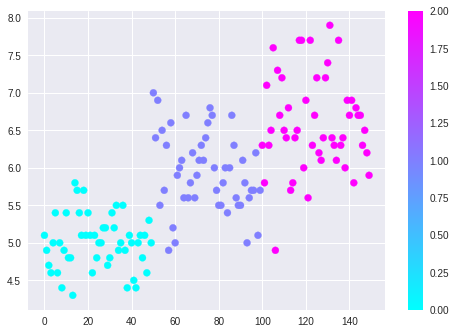

In [22]:
plt.scatter(range(len(x)), x[:,0], c=y, cmap='cool')
plt.colorbar()
plt.show()

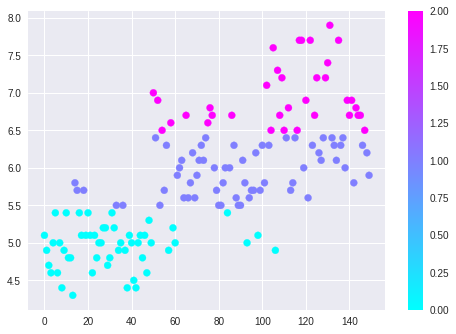

In [23]:
def heuristic_predict(flower_data):
  if flower_data[0] < 5.5:
    return 0
  elif flower_data[0] < 6.5:
    return 1
  else:
    return 2
  
def heuristic_predict_many(flower_datas):
  return [heuristic_predict(flower_data) for flower_data in flower_datas]
  
  
heuristic_predictions = heuristic_predict_many(x)

plt.scatter(range(len(x)), x[:,0], c=heuristic_predictions, cmap='cool')
plt.colorbar()
plt.show()

# productionise the heuristic model with Cloud Functions

![alt text](https://github.com/ZackAkil/OReilly-AI-Conference-Pragmatic-ML/raw/master/cloud_function.png)

In [0]:
import requests

In [0]:
function_url = "https://us-central1-oreilly-ai-conf-demo-za.cloudfunctions.net/heuristic-not-iris-predict"

In [26]:
req = requests.post(function_url, json={'instances':[[6, 3.1, 4.1, 0]]})
req.json()

{'predictions': [1]}

# build first ml model

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42)

In [29]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
tree.score(X_test, y_test)

0.98

# Compare heuristic vs first ML model

In [0]:
from sklearn.metrics import accuracy_score

In [32]:
accuracy_score(tree.predict(X_test), y_test)

0.98

In [33]:
accuracy_score(heuristic_predict_many(X_test), y_test)

0.72

# productionise first ML model (scikit learn)

## exporting model

In [0]:
from sklearn.externals import joblib 

In [35]:
joblib.dump(tree, 'model.joblib')

['model.joblib']

In [0]:
# Authenticate to GCP
from google.colab import auth
auth.authenticate_user()

In [22]:
# slick way of getting the model into cloud stroage

!gsutil cp model.joblib gs://ai-sklearn-models/tree/model.joblib

Copying file://model.joblib [Content-Type=application/octet-stream]...
/ [1 files][  2.8 KiB/  2.8 KiB]                                                
Operation completed over 1 objects/2.8 KiB.                                      


## calling model from ml-engine (from cloud function)
Check out [this blog post](https://cloud.google.com/blog/products/ai-machine-learning/simplifying-ml-predictions-with-google-cloud-functions) on how that cloud function works

In [0]:
ml_engine_url = 'https://us-central1-oreilly-ai-conf-demo-za.cloudfunctions.net/ml-engine-predict'

In [37]:
req = requests.post(ml_engine_url, json={'instances':[[0,2,0,0]], 'model':'not_iris'})
req.json()

{'predictions': [0]}

# build more complex ML model (tensorflow)

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
# def serving_input_receiver_fn():
  
#     inputs = {
#       input_layer_name: tf.placeholder(tf.float32, [None, 4]),
#     }
#     return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [64]:
my_feature_columns = [tf.feature_column.numeric_column('flower_features', shape=[4])]

classifier = tf.estimator.DNNClassifier(
        feature_columns=my_feature_columns,
        # Two hidden layers of 10 nodes each.
        hidden_units=[10, 10],
        # The model must choose between 3 classes.
        n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp06193gxe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa2ea699b38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
def input_fn():
    def _fn():
        features = {'flower_features': tf.constant(X_train)}
        label = tf.constant(y_train)
        return features, label
    return _fn

In [66]:
classifier.train(input_fn=input_fn(), steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp06193gxe/model.ckpt.
INFO:tensorflow:loss = 119.287994, step = 1
INFO:tensorflow:global_step/sec: 920.138
INFO:tensorflow:loss = 13.776446, step = 101 (0.110 sec)
INFO:tensorflow:global_step/sec: 1298.84
INFO:tensorflow:loss = 8.034527, step = 201 (0.081 sec)
INFO:tensorflow:global_step/sec: 1185.56
INFO:tensorflow:loss = 6.576059, step = 301 (0.084 sec)
INFO:tensorflow:global_step/sec: 1232.52
INFO:tensorflow:loss = 5.9631453, step = 401 (0.079 sec)
INFO:tensorflow:global_step/sec: 1241.76
INFO:tensorflow:loss = 5.724994, step = 501 (0.080 sec)
INFO:tensorflow:global_step/sec: 1305.07
INFO:tensorflow:loss = 5.345947, step = 601 (0.076 sec)
INFO:tensorflow:global_step/sec: 1258.77
INFO:tensorflow:los

In [67]:
classifier.evaluate(input_fn=input_fn(), steps=100)["accuracy"] 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-09-13:50:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp06193gxe/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-10-09-13:50:49
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.99, average_loss = 0.041496295, global_step = 1000, loss = 4.1496296
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp06193gxe/model.ckpt-1000


0.99

In [0]:
# feature_spec = {'flower_features': tf.FixedLenFeature(shape=[4], dtype=np.float32)}

# serving_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_spec)

In [0]:
def serving_input_receiver_fn():
    inputs = {
      'flower_features': tf.placeholder(tf.float32, [None, 4]),
    }
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [70]:
classifier.export_savedmodel(export_dir_base='/tmp/not_iris_model' + '/export', 
                            serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'flower_features': <tf.Tensor 'Placeholder:0' shape=(?, 4) dtype=float32>}
INFO:tensorflow:'classification' : Classification input must be a single string Tensor; got {'flower_features': <tf.Tensor 'Placeholder:0' shape=(?, 4) dtype=float32>}
INFO:tensorflow:Restoring parameters from /tmp/tmp06193gxe/model.ckpt-1000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:te

b'/tmp/not_iris_model/export/1539093055'

In [71]:
!ls /tmp/not_iris_model/export/1539093055

saved_model.pb	variables


In [72]:
!gsutil cp -r /tmp/not_iris_model/export/1539093055 gs://ai-tf-models/tf-estimator

Copying file:///tmp/not_iris_model/export/1539093055/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///tmp/not_iris_model/export/1539093055/variables/variables.index [Content-Type=application/octet-stream]...
Copying file:///tmp/not_iris_model/export/1539093055/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [3 files][ 32.3 KiB/ 32.3 KiB]                                                
Operation completed over 3 objects/32.3 KiB.                                     


## Call tensorflow model from ml-engine (from cloud function)
Check out [this blog post](https://cloud.google.com/blog/products/ai-machine-learning/simplifying-ml-predictions-with-google-cloud-functions)  on how that cloud function works

In [56]:
tf_engine_url = 'https://us-central1-oreilly-ai-conf-demo-za.cloudfunctions.net/ml-engine-predict'

req = requests.post(ml_engine_url, json={'instances':[[5,2,0,5]], 
                                         'model':'not_iris/versions/v3'})
req.json()

{'predictions': [{'class_ids': [1],
   'classes': ['1'],
   'logits': [-6.27042818069458, 2.826831340789795, -0.4603240489959717],
   'probabilities': [0.00010792798275360838,
    0.9638815522193909,
    0.036010585725307465]}]}

# Putting it into an app

In [0]:
from IPython.core.display import display, HTML

In [74]:
#@title Inline HTML app { run: "auto" }
api_url = "https://us-central1-oreilly-ai-conf-demo-za.cloudfunctions.net/ml-engine-predict" #@param {type:"string"}
model_name = "not_iris/versions/ten" #@param {type:"string"}





display(HTML('''


<form action="/action_page.php">

  <div>
  Sepal Length:<span>2</span><br>
  <input type="range" name="sepal-length" 
           min="0" max="10" value="2" step="0.1" />
  </div>
  <br>
  <div>
  Sepal Width:<span>2</span><br>
  <input type="range" name="sepal-width" 
           min="0" max="10" value="2" step="0.1" />
  </div>
  <br>
  <div>
   Petal Length:<span>2</span><br>
  <input type="range" name="petal-length" 
           min="0" max="10" value="2" step="0.1" />
  </div>
  <br>
  <div>
   Petal Width:<span>2</span><br>
  <input type="range" name="petal-width" 
           min="0" max="10" value="2" step="0.1"/>
  </div>
  <br>
</form>

<input id="submit" type="submit" value="Submit">
<br>
<br>
<pre>
<code id="pred">
</code>
</pre>


<script src="https://ajax.googleapis.com/ajax/libs/jquery/1.8.2/jquery.min.js"></script>


<script type="text/javascript">

$(document).on("input", "input[type=range]", function(){
     $(this).siblings("span").text($(this).val())
});



const api_url = "'''+api_url+'''"

$("#submit").click(function () {
               
               var inputs = []
               $("input[type=range]").each(function(){
                inputs.push(parseInt($(this).val()))
               
               });

               $.ajax({
                    type: "POST",
                    url: api_url,
                    data: JSON.stringify({
                        "instances": [inputs],
                        "model":"'''+model_name+'''"
                    }),

                    contentType: "application/json; charset=utf-8",
                    dataType: "json",
                    success: function (data) {
                    var pred = JSON.stringify(data, null, 2)
                    console.log(pred);
                    $("#pred").text(pred)
                    },   
                    beforeSend: function () {
                        $("#pred").text("")
                    }

                });

});

</script>


'''))